In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import tensorflow as tf
import os

## Pre processing

In [5]:
IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT = 3, 512, 512

In [7]:
X_names = next(os.walk('archive/segmentation_full_body_mads_dataset_1192_img/images'))[2]
y_names = next(os.walk('archive/segmentation_full_body_mads_dataset_1192_img/masks'))[2]

In [8]:
X_train = np.zeros((len(X_names), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_names), 256, 256, 1), dtype=np.bool)

In [10]:
for i, _id in enumerate(X_names):
    image = tf.keras.preprocessing.image.load_img(f'archive/segmentation_full_body_mads_dataset_1192_img/images/{_id}', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    input_array = tf.keras.preprocessing.image.img_to_array(image)[90:450, 150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_array, ).resize((256, 256))
    X_train[i] = np.array(image)

In [12]:
for i, _id in enumerate(y_names):
    image = tf.keras.preprocessing.image.load_img(f'archive/segmentation_full_body_mads_dataset_1192_img/masks/{_id}', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), color_mode="grayscale")
    input_array = tf.keras.preprocessing.image.img_to_array(image)[90:450, 150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_array).resize((256, 256))
    y_train[i] = np.array(image)[:, :, np.newaxis]

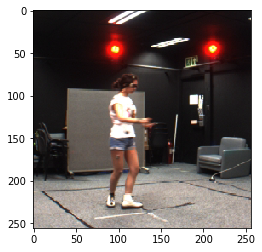

In [14]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_train[500]))

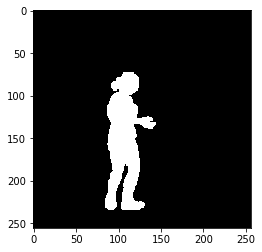

In [15]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(y_train[500]))

## Model building

In [16]:
inputs = tf.keras.layers.Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

In [18]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 


In [19]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
_______________________________________________________________________________________

In [20]:
trained_model = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25)

Epoch 1/25
67/67 [==============================] - 437s 7s/step - loss: 0.3599 - accuracy: 0.8762 - val_loss: 0.2555 - val_accuracy: 0.8725
Epoch 2/25
67/67 [==============================] - 490s 7s/step - loss: 0.1623 - accuracy: 0.9346 - val_loss: 0.1886 - val_accuracy: 0.9033
Epoch 3/25
67/67 [==============================] - 416s 6s/step - loss: 0.0809 - accuracy: 0.9681 - val_loss: 0.1202 - val_accuracy: 0.9532
Epoch 4/25
67/67 [==============================] - 546s 8s/step - loss: 0.0518 - accuracy: 0.9800 - val_loss: 0.0896 - val_accuracy: 0.9660
Epoch 5/25
67/67 [==============================] - 607s 9s/step - loss: 0.0527 - accuracy: 0.9802 - val_loss: 0.1006 - val_accuracy: 0.9609
Epoch 6/25
67/67 [==============================] - 544s 8s/step - loss: 0.0388 - accuracy: 0.9849 - val_loss: 0.0622 - val_accuracy: 0.9759
Epoch 7/25
67/67 [==============================] - 565s 8s/step - loss: 0.0317 - accuracy: 0.9875 - val_loss: 0.0591 - val_accuracy: 0.9770
Epoch 8/25
67

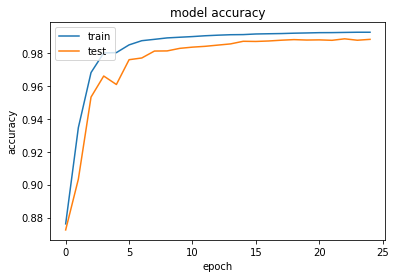

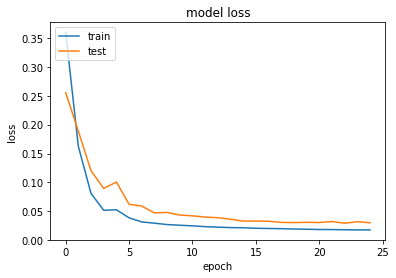

In [22]:
# accuracy
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#  loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
import random

In [24]:
test = random.choice(X_names)
print(test)

Taichi_S1_C0_00450.png


In [26]:
image = tf.keras.preprocessing.image.load_img(f'archive/segmentation_full_body_mads_dataset_1192_img/images/{test}', target_size=(256, 256))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
prediction = model.predict(input_arr)

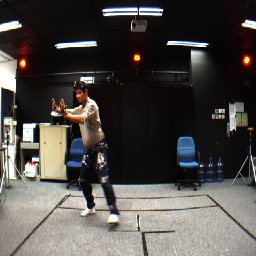

In [30]:
Image.open(f'archive/segmentation_full_body_mads_dataset_1192_img/images/{test}').resize((256, 256))

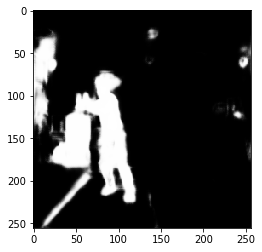

In [32]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.squeeze(prediction)[:, :, np.newaxis]))

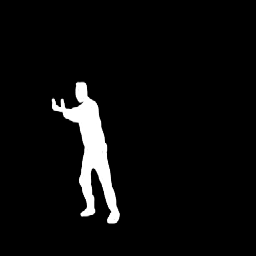

In [33]:


Image.open(f'archive/segmentation_full_body_mads_dataset_1192_img/masks/{test}').resize((256 ,256))

